In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from skmisc.loess import loess
import seaborn as sns
from tqdm import tqdm

In [2]:
def train_test_prod_split(data, target, n_train, n_test, n_prod):
    # sample deplyoment point
    deployment_idx = np.random.randint(n_train + n_test, len(data) - 2 * n_train)
    idx_test_end = deployment_idx 
    idx_test_start = deployment_idx - n_test
    
    idx_train_start = idx_test_start - n_train
    idx_train_end = idx_test_start
    
    idx_prod_start = np.random.randint(deployment_idx, deployment_idx + 2 * n_train)
    idx_prod_end = idx_prod_start + n_prod

    # split data
    X_train = data.iloc[idx_train_start:idx_train_end]
    X_test = data.iloc[idx_test_start:idx_test_end]
    X_prod = data.iloc[idx_prod_start:idx_prod_end]
    
    # split targets
    y_train = target.iloc[idx_train_start:idx_train_end]
    y_test = target.iloc[idx_test_start:idx_test_end]
    y_prod = target.iloc[idx_prod_start:idx_prod_end]
    
    # TODO: return only 3 objects df_train, ... targets next to data
    return X_train, X_test, X_prod, y_train, y_test, y_prod

In [3]:
def compute_model_errors(data, target, model, n_train, n_test, n_prod):
    # create random split
    X_train, X_test, X_prod, y_train, y_test, y_prod = train_test_prod_split(data, target, n_train, n_test, n_prod)
    
    # cross-validation for timeseries
    tscv = TimeSeriesSplit(n_splits=4)
    train_errors = []
    val_errors = []
    y_dict = {}
    for i, (train_index, val_index) in enumerate(tscv.split(X_train)):
        X_train_fold = X_train.iloc[train_index]
        y_train_fold = y_train.iloc[train_index]
        
        X_val_fold = X_train.iloc[val_index]
        y_val_fold = y_train.iloc[val_index]
        
        # train the model
        model.fit(X_train, y_train)
    
        # make predictions
        y_train_pred_fold = model.predict(X_train_fold)
        y_val_pred_fold = model.predict(X_val_fold)
        
        # calculate fold errors
        # TODO: allow other metrics
        train_error_fold = mean_absolute_percentage_error(y_train_fold, y_train_pred_fold)
        val_error_fold = mean_absolute_percentage_error(y_val_fold,  y_val_pred_fold)
        
        train_errors.append(train_error_fold)
        val_errors.append(val_error_fold)
        
    # rule for a valid model
    # TODO: pass this as a parameter
    if np.mean(val_errors) < 0.2 and np.mean(train_errors) < 0.2:
        is_model_valid = True
    else:
        is_model_valid = False
    
    # train on all the data
    X = pd.concat([X_train, X_test])
    y = pd.concat([y_train, y_test])
    model.fit(X, y)
    y_train_pred = model.predict(X)
    y_test_pred = model.predict(X_test)
    y_prod_pred = model.predict(X_prod)
    
    y_train_dict = {}
    y_test_dict = {}
    y_prod_dict = {}
    
    y_train_dict['y'] = y
    y_train_dict['y_pred'] = y_train_pred
    y_train_dict['partition'] = 'train'
    
    y_test_dict['y'] = y_test
    y_test_dict['y_pred'] = y_test_pred
    y_test_dict['partition'] = 'test'
    
    y_prod_dict['y'] = y_prod
    y_prod_dict['y_pred'] = y_prod_pred
    y_prod_dict['partition'] = 'prod'
        
    return y_train_dict, y_test_dict, y_prod_dict, is_model_valid

In [4]:
def generate_model_errors_dataframe(y_train_dict, y_test_dict, y_prod_dict, simulation_id, is_model_valid):
    train_results_df = pd.DataFrame(y_train_dict)
    test_results_df = pd.DataFrame(y_test_dict)
    prod_results_df = pd.DataFrame(y_prod_dict)

    results_df = pd.concat([train_results_df, test_results_df, prod_results_df])
    results_df['timestamp'] = results_df.index
    #errors_df = errors_df.rename(columns={"demand": "error"})

    # check this
    results_df['model_age'] = (results_df.index - train_results_df.index[-1]).days
    results_df['is_model_valid'] = is_model_valid
    results_df['simulation_id'] = simulation_id
    
    return results_df

In [5]:
def evaluation_runner(data, target, model, n_train, n_test, n_prod, n_simulations=1):
    # empty error lists
    results_df_list = []
    
    # for every simulation compute the models errors, append the errors to the error lists
    for i in tqdm(range(n_simulations)):
        
        model.set_params(random_state=np.random.randint(0, n_simulations))
        y_train_results, y_test_results, y_prod_results, is_model_valid = compute_model_errors(data, target, 
                                                                                      model, n_train, 
                                                                                      n_test, n_prod)
    
        # generate a single error dataframe
        results_df = generate_model_errors_dataframe(y_train_results, y_test_results,
                                                     y_prod_results, i, is_model_valid)
        results_df_list.append(results_df)
    
    results_df = pd.concat(results_df_list)
    
    return results_df

In [6]:
def aggregate_errors_data(errors_df, metric, freq='D', only_valid_models=True):
    # TODO: clean this function
    # This function aggregates data in time frequencies and also checks if a model is valid
    
    freq_errors_df = errors_df.groupby(['partition', 'simulation_id', pd.Grouper(key='timestamp', freq='D')]) \
                              .apply(lambda group: metric(group.y, group.y_pred)) \
                              .rename("error").reset_index().sort_values(['simulation_id', 'timestamp'])

    last_train_dates_df = freq_errors_df[freq_errors_df['partition'] == 'train'] \
                            .groupby(['simulation_id']) \
                            .agg(last_val_date=('timestamp', 'max')) \
                            .reset_index()

    freq_errors_df = pd.merge(freq_errors_df, last_train_dates_df, on='simulation_id', how='left')
    freq_errors_df['model_age'] = (freq_errors_df['timestamp'] - 
                                   freq_errors_df['last_val_date']) / np.timedelta64(1, freq)
        
    model_validity_df = errors_df[['simulation_id', 'is_model_valid']].drop_duplicates()
    freq_errors_df = pd.merge(freq_errors_df, model_validity_df, on='simulation_id', how='left')
    
    test_results_df = errors_df[errors_df['partition'] == 'test']
    test_error = metric(test_results_df['y'], test_results_df['y_pred'])
    
    relative_errors = freq_errors_df['error'] / test_error
    freq_errors_df['error_rel'] = relative_errors
    
    if only_valid_models:    
        freq_errors_df = freq_errors_df[freq_errors_df['is_model_valid'] == True]
    
    return freq_errors_df

In [7]:
def get_trend_lines(data, quantiles, metric):
    trend_lines = []
    data = data[data['partition'] == 'prod']
    
    for q in quantiles:
        trend_line = {}
        q_df = data.groupby(['model_age'])[metric].agg(lambda x: x.quantile([q])).rename(metric).reset_index() 
        x = q_df['model_age']
        y = q_df[metric]

        l = loess(x, y, degree=2, span=0.05)
        l.fit()
        pred = l.predict(x, stderror=True)
        lowess = pred.values
        
        trend_line['quantile'] = q
        trend_line['model_age'] = x
        trend_line[metric] = lowess
        trend_lines.append(trend_line)
    
    trend_lines_df = pd.DataFrame(trend_lines)
    trend_lines_df = trend_lines_df.explode(['model_age', metric]).reset_index(drop=True)
    return trend_lines_df

## Experiment Set Up

In [8]:
dataset = 'cal_house'
data, target = fetch_california_housing(as_frame=True, return_X_y=True)
timestamp = pd.date_range(start='1/1/2018', periods=len(data), freq='H')
data.index = timestamp
target.index = timestamp

n_train = 5000
n_test = 2500
n_prod = 3000
n_simulations = 100
model = LGBMRegressor()
metric = mean_absolute_percentage_error

errors_df = evaluation_runner(data, target, model, n_train, n_test, n_prod, n_simulations)
errors_df.to_parquet(f'../results/aging/{dataset}/aging_{dataset}_{n_simulations}_simulations_{n_prod}_prod.parquet')

100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.27it/s]


In [9]:
n_valid_models = errors_df[['simulation_id', 'is_model_valid']].drop_duplicates()['is_model_valid'].sum()
print(f"There are {n_valid_models} valid models out of {n_simulations} simulations.")

There are 100 valid models out of 100 simulations.


In [10]:
d_errors_df = aggregate_errors_data(errors_df, metric=metric, freq='D', only_valid_models=True)
d_errors_df.to_parquet(f'../results/aging/{dataset}/aging_{dataset}_{n_simulations}_simulations_{n_prod}_prod_daily.parquet')

### Plot Error

In [11]:
trend_lines_df = get_trend_lines(data=d_errors_df, quantiles=[0.25, 0.50, 0.75], metric='error')

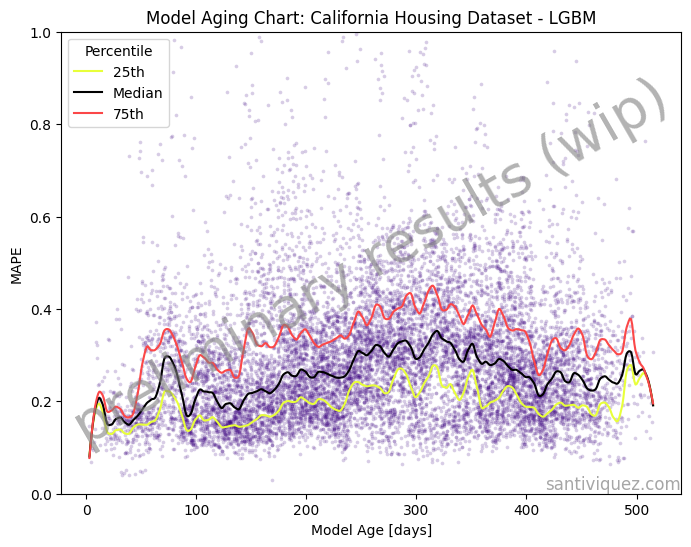

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(data=trend_lines_df, x='model_age', y='error', linewidth=1.5,
             palette=['#E8FF3A', 'black', '#FB4748'], hue='quantile', legend=False, ax=ax)

sns.scatterplot(data=d_errors_df[d_errors_df['partition'] == 'prod'],
                x='model_age', y='error', s=7, alpha=0.20, color='#3b0280', linewidth=0, ax=ax)

ax.legend(title='Percentile', labels=['25th', 'Median', '75th'])
ax.set_xlabel('Model Age [days]')
ax.set_ylabel('MAPE')
ax.set_ylim(0, 1)

ax.text(0.5, 0.5, 'preliminary results (wip)', transform=ax.transAxes,
        fontsize=40, color='gray', alpha=0.6,
        ha='center', va='center', rotation=30)
ax.text(1, 0.04, 'santiviquez.com', transform=ax.transAxes,
        fontsize=12, color='gray', alpha=0.7,
        ha='right', va='top')

ax.set_title('Model Aging Chart: California Housing Dataset - LGBM')
plt.savefig('../figures/sketch_age_chart_calhouse_lgbm_MAPE.svg', format='svg')
plt.show()

### Plot Relative Error

In [13]:
trend_lines_df = get_trend_lines(data=d_errors_df, quantiles=[0.25, 0.50, 0.75], metric='error_rel')

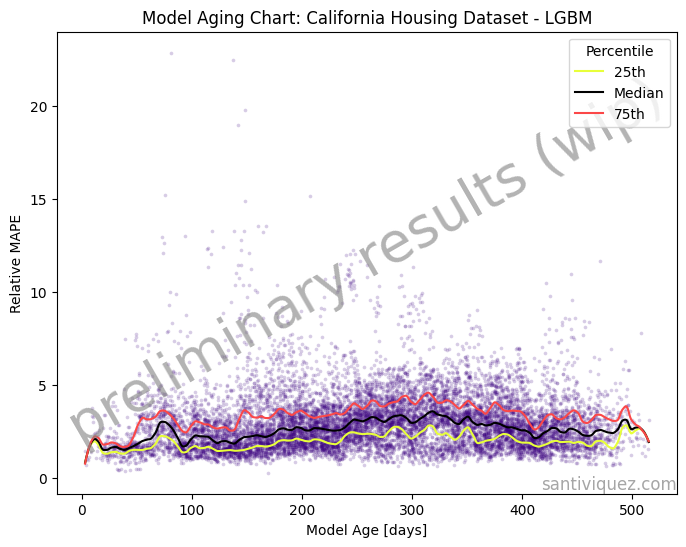

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(data=trend_lines_df, x='model_age', y='error_rel', linewidth=1.5,
             palette=['#E8FF3A', 'black', '#FB4748'], hue='quantile', legend=False, ax=ax)

sns.scatterplot(data=d_errors_df[d_errors_df['partition'] == 'prod'],
                x='model_age', y='error_rel', s=7, alpha=0.20, color='#3b0280', linewidth=0, ax=ax)

ax.legend(title='Percentile', labels=['25th', 'Median', '75th'])
ax.set_xlabel('Model Age [days]')
ax.set_ylabel('Relative MAPE')

ax.text(0.5, 0.5, 'preliminary results (wip)', transform=ax.transAxes,
        fontsize=40, color='gray', alpha=0.6,
        ha='center', va='center', rotation=30)
ax.text(1, 0.04, 'santiviquez.com', transform=ax.transAxes,
        fontsize=12, color='gray', alpha=0.7,
        ha='right', va='top')

ax.set_title('Model Aging Chart: California Housing Dataset - LGBM')
plt.savefig('../figures/sketch_age_chart_calhouse_lgbm_Relative_MAPE.svg', format='svg')
plt.show()

TODO:

* automatic hyperparameter tunning 